# [COM4513-6513] Assignment 1: Text Classification with Logistic Regression

### Instructor: Nikos Aletras


The goal of this assignment is to develop and test two text classification systems: 

- **Task 1:** sentiment analysis, in particular to predict the sentiment of movie review, i.e. positive or negative (binary classification).
- **Task 2:** topic classification, to predict whether a news article is about International issues, Sports or Business (multiclass classification).


For that purpose, you will implement:

- Text processing methods for extracting Bag-Of-Word features, using (1) unigrams, bigrams and trigrams to obtain vector representations of documents. Two vector weighting schemes should be tested: (1) raw frequencies (**3 marks; 1 for each ngram type**); (2) tf.idf (**1 marks**). 
- Binary Logistic Regression classifiers that will be able to accurately classify movie reviews trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 1. 
- Multiclass Logistic Regression classifiers that will be able to accurately classify news articles trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 2. 
- The Stochastic Gradient Descent (SGD) algorithm to estimate the parameters of your Logistic Regression models. Your SGD algorithm should:
    - Minimise the Binary Cross-entropy loss function for Task 1 (**3 marks**)
    - Minimise the Categorical Cross-entropy loss function for Task 2 (**3 marks**)
    - Use L2 regularisation (both tasks) (**1 mark**)
    - Perform multiple passes (epochs) over the training data (**1 mark**)
    - Randomise the order of training data after each pass (**1 mark**)
    - Stop training if the difference between the current and previous validation loss is smaller than a threshold (**1 mark**)
    - After each epoch print the training and development loss (**1 mark**)
- Discuss how did you choose hyperparameters (e.g. learning rate and regularisation strength)?  (**2 marks; 0.5 for each model in each task**).
- After training the LR models, plot the learning process (i.e. training and validation loss in each epoch) using a line plot (**1 mark; 0.5 for both BOW-count and BOW-tfidf LR models in each task**) and discuss if your model overfits/underfits/is about right.
- Model interpretability by showing the most important features for each class (i.e. most positive/negative weights). Give the top 10 for each class and comment on whether they make sense (if they don't you might have a bug!).  If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain? (**2 marks; 0.5 for BOW-count and BOW-tfidf LR models respectively in each task**)


### Data - Task 1 

The data you will use for Task 1 are taken from here: [http://www.cs.cornell.edu/people/pabo/movie-review-data/](http://www.cs.cornell.edu/people/pabo/movie-review-data/) and you can find it in the `./data_sentiment` folder in CSV format:

- `data_sentiment/train.csv`: contains 1,400 reviews, 700 positive (label: 1) and 700 negative (label: 0) to be used for training.
- `data_sentiment/dev.csv`: contains 200 reviews, 100 positive and 100 negative to be used for hyperparameter selection and monitoring the training process.
- `data_sentiment/test.csv`: contains 400 reviews, 200 positive and 200 negative to be used for testing.

### Data - Task 2

The data you will use for Task 2 is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.


### Submission Instructions

You should submit a Jupyter Notebook file (assignment1.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy and Pandas. You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc..

Please make sure to comment your code. You should also mention if you've used Windows (not recommended) to write and test your code. There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 20. It is worth 20\% of your final grade in the module.

The deadline for this assignment is **23:59 on Fri, 20 Mar 2020** and it needs to be submitted via MOLE. Standard departmental penalties for lateness will be applied. We use a range of strategies to detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index), including Turnitin which helps detect plagiarism, so make sure you do not plagiarise.



## Load Raw texts and labels into arrays

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [1]:
import pandas as pd
import numpy as np
import random
import re
import timeit
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from math import log

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


In [2]:
# Throughout the assignment, I will denote variables associated with 2
# with 2 at the end of the variable name.

# Task 1 data sets
train_set1 = pd.read_csv('./data_sentiment/train.csv', header = None, names = ['text', 'label'])
test_set1 = pd.read_csv('./data_sentiment/test.csv', header = None, names = ['text', 'label'])
dev_set1 = pd.read_csv('./data_sentiment/dev.csv', header = None, names = ['text', 'label'])

# Task 2 data sets
train_set2 = pd.read_csv('./data_topic/train.csv', header = None, names = ['label', 'text'])
test_set2 = pd.read_csv('./data_topic/test.csv', header = None, names = ['label', 'text'])
dev_set2 = pd.read_csv('./data_topic/dev.csv', header = None, names = ['label', 'text'])



If you use Pandas you can see a sample of the data.

In [3]:
dev_set2[45:55]

,label,text
45,1,AP - Vice President Dick Cheney said Tuesday t...
46,1,"Baghdad, Sept. 8 (NNN): Bloody clashes on Tues..."
47,1,DUBAI/PARIS (Reuters) - The French government...
48,1,NEW YORK - Investors were unmoved by Federal R...
49,1,Bandar Seri Begawan - Bruneis Royal Wedding be...
50,2,"LONDON, England -- Andrew Symonds rode his luc..."
51,2,"For most tennis players, having about the same..."
52,2,AP - It was the surest sign that the Kobe Brya...
53,2,AP - Drew Tate threw two touchdowns in his fir...
54,2,Brian Kerr took his Ireland squad to the dogs ...


The next step is to put the raw texts into Python lists and their corresponding labels into NumPy arrays:


In [4]:
# Task 1 label array and raw text list definitions

Y_tr = np.array(train_set1['label'])
Y_test = np.array(test_set1['label'])
Y_dev = np.array(dev_set1['label'])

train_text1 = [text for text in train_set1['text']]
test_text1 = [text for text in test_set1['text']]
dev_text1 = [text for text in dev_set1['text']]

# Task 2 label array and raw text list definitions

Y_tr2 = np.array(train_set2['label'])
Y_test2 = np.array(test_set2['label'])
Y_dev2 = np.array(dev_set2['label'])

train_text2 = [text for text in train_set2['text']]
test_text2 = [text for text in test_set2['text']]
dev_text2 = [text for text in dev_set2['text']]

# Bag-of-Words Representation 


To train and test Logisitc Regression models, you first need to obtain vector representations for all documents given a vocabulary of features (unigrams, bigrams, trigrams).


## Text Pre-Processing Pipeline

To obtain a vocabulary of features, you should: 
- **tokenise** all texts into a list of unigrams (tip: using a regular expression) 
- remove **stop words** (using the one provided or one of your preference) 
- compute bigrams, trigrams given the remaining unigrams
- **remove ngrams appearing in less than K documents**
- use the remaining to create a vocabulary of unigrams, bigrams and trigrams (you can keep top N if you encounter memory issues).


In [5]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what', 
             'his', 'her', 'they', 'them', 'from', 'with', 'its', 'is', 'The']

### N-gram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.

See the examples below to see how this function should work.

In [6]:
# Function to extract ngrams of one length n

def ngrams(x_raw, n=3, token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[]):
   
    x_list = re.findall(token_pattern, x_raw)               
    unigrams = [word for word in x_list if word not in stop_words]
    ngrams = [tuple(unigrams[i:i+n]) for i in range(len(unigrams)-n+1)]
    
    return ngrams

# Extract ngrams which uses previous function to get ngrams of all numbers up to n

def extract_ngrams(x_raw, n=3, token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words=[], vocab=set()):
    all_ngrams = []
    for i in range(1, n+1):
        ngrams_i = ngrams(x_raw, n=i, token_pattern=token_pattern, stop_words=stop_words)
        for x in ngrams_i:
            ngram = ' '.join(x)
            all_ngrams.append(ngram)
            
    if vocab != set():
        all_ngrams = vocab
        
    return all_ngrams

In [7]:
extract_ngrams(x_raw = "this is a great movie to the watch the", stop_words=stop_words)

['great', 'movie', 'watch', 'great movie', 'movie watch', 'great movie watch']

Note that it is OK to represent n-grams using lists instead of tuples: e.g. `['great', ['great', 'movie']]`

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab

Hint: it should make use of the `extract_ngrams` function.

In [8]:
def get_vocab(X_raw, n=3, token_pattern=r'\b[A-Za-z][A-Za-z]+\b', min_df=0, keep_topN=0, stop_words=[]):
    # Dictionaries for term frquency and document frequency
    df = {}
    tf = {}
    for text in X_raw:
        ngrams = extract_ngrams(text, n=n, token_pattern=token_pattern, stop_words=stop_words) # To populate tf
        ngrams_unique = set(ngrams) # To populate df
        
        for ngram in ngrams_unique:
            if ngram in df:
                df[ngram] += 1
            else:
                df[ngram] = 1

        for ngram in ngrams:
            if ngram in tf:
                tf[ngram] += 1
            else:
                tf[ngram] = 1
    
    
    for ngram, count in df.items():
        if count < min_df:
            df.pop(ngram)
            tf.pop(ngram)
    
    if keep_topN != 0:
        #df = dict(Counter(df).most_common(keep_topN))
        tf = dict(Counter(tf).most_common(keep_topN))
    
    for ngram in list(df.keys()):
        if ngram not in tf.keys():
            df.pop(ngram)
    
    vocab = set(tf.keys())
    ngram_counts = list(tf.values())    
    
    return vocab, df, ngram_counts

# list.sort() sorts any list of strings into alphabetical order

In [9]:
# Testing function with small data.
# X_raw = ["great movie Ruaridh great movie",
#          "have never watched is movie the",
#          "today Ruaridh watched movie dinner today"]

# get_vocab(X_raw, keep_topN = 20)

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of n-grams:

In [10]:
vocab, df, ngram_counts = get_vocab(train_text1, n=3, keep_topN=5000, stop_words=stop_words)
print(len(vocab))
print()
print(list(vocab)[:50])
print()
print(Counter(df).most_common()[:10])

5000

['tell', 'past', 'carrie', 'south', 'connected', 'reads', 'sequels', 'visuals', 'answer', 'replaced', 'mature', 'cannot', 'wes', 'kilmer', 'fighter', 'marshall', 'indiana', 'delight', 'stone', 'cuba', 'see film', 'advice', 'more time', 'reveals', 'reading', 'client', 'gross', 'master', 'shame', 'film festival', 'enjoyable', 'black cauldron', 'eight', 'sympathy', 'film just', 'many people', 'wahlberg', 'hitchcock', 'refuses', 'fifth', 'imagery', 'sort', 'max', 'nearby', 'abandoned', 'episodes', 'guest', 'high school', 'alien', 'terry']

[('but', 1334), ('one', 1247), ('film', 1231), ('not', 1170), ('all', 1117), ('movie', 1095), ('out', 1080), ('so', 1047), ('there', 1046), ('like', 1043)]


Then, you need to create vocabulary id -> word and id -> word dictionaries for reference:

In [11]:
vocab_id = {i:list(vocab)[i] for i in range(len(vocab))}

Now you should be able to extract n-grams for each text in the training, development and test sets:

In [12]:
vocab_test, df_test, ngram_counts_test = get_vocab(test_text1, n=3, keep_topN=5000, stop_words=stop_words)
vocab_dev, df_dev, ngram_counts_dev = get_vocab(dev_text1, n=3, keep_topN=5000, stop_words=stop_words)


## Vectorise documents 

Next, write a function `vectoriser` to obtain Bag-of-ngram representations for a list of documents. The function should take as input:
- `X_ngram`: a list of texts (documents), where each text is represented as list of n-grams in the `vocab`
- `vocab`: a set of n-grams to be used for representing the documents

and return:
- `X_vec`: an array with dimensionality Nx|vocab| where N is the number of documents and |vocab| is the size of the vocabulary. Each element of the array should represent the frequency of a given n-gram in a document.


In [13]:
# First create function that returns X_ngram

def extract_X_ngram(data):
    X_ngram = []
    for text in data:
        ngrams = list(extract_ngrams(text, stop_words=stop_words))
        X_ngram.append(ngrams)
    return X_ngram

def vectorise(X_ngram, vocab):
    X_vec = np.zeros([len(X_ngram), len(vocab)])
    i=0    
    for doc in X_ngram:
        doc_counter = Counter(doc)
        for id, ngram in vocab_id.items():
            X_vec[i][id] = doc_counter[ngram] 
        i+=1
    return X_vec

Finally, use `vectorise` to obtain document vectors for each document in the train, development and test set. You should extract both count and tf.idf vectors respectively:

#### Count vectors

In [14]:
X_tr = extract_X_ngram(train_text1)
X_tr_count = vectorise(X_tr, vocab)

X_test = extract_X_ngram(test_text1)
X_test_count = vectorise(X_test, vocab)

X_dev = extract_X_ngram(dev_text1)
X_dev_count = vectorise(X_dev, vocab)

#### TF.IDF vectors

First compute `idfs` an array containing inverted document frequencies (Note: its elements should correspond to your `vocab`)

In [15]:
# Create a list of the idf values for each word by iterating over document frequencies

df_counts = list(df.values())

idf = [log(len(X_tr)/i) for i in df_counts]
idf_test = [log(len(X_test)/i) for i in df_counts]
idf_dev = [log(len(X_dev)/i) for i in df_counts]

Then transform your count vectors to tf.idf vectors:

In [16]:
# Populate each row of the tfidf array by using the count array multiplied by the appropriate idf value

X_tr_tfidf = np.zeros(X_tr_count.shape)
X_test_tfidf = np.zeros(X_test_count.shape)
X_dev_tfidf = np.zeros(X_dev_count.shape)

for i in range(len(X_tr_count)):
    X_tr_tfidf[i] = X_tr_count[i]*idf
    
for i in range(len(X_test_count)):
    X_test_tfidf[i] = X_test_count[i]*idf_test
    
for i in range(len(X_dev_count)):
    X_dev_tfidf[i] = X_dev_count[i]*idf_dev

# Binary Logistic Regression

After obtaining vector representations of the data, now you are ready to implement Binary Logistic Regression for classifying sentiment.

First, you need to implement the `sigmoid` function. It takes as input:

- `z`: a real number or an array of real numbers 

and returns:

- `sig`: the sigmoid of `z`

In [17]:
def sigmoid(z):
    sig = 1 / (1 + np.exp(-z))
    return sig

In [18]:
print(sigmoid(0)) 
print(sigmoid(np.array([-5., 1.2])))

0.5
[0.00669285 0.76852478]


Then, implement the `predict_proba` function to obtain prediction probabilities. It takes as input:

- `X`: an array of inputs, i.e. documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_proba`: the prediction probabilities of X given the weights

In [19]:
def predict_proba(X, weights):
    z = np.dot(X, weights)
    preds_proba = sigmoid(z)
    return preds_proba

In [20]:
#for i in X_tr_count: print(Counter(i), '\n')

Then, implement the `predict_class` function to obtain the most probable class for each vector in an array of input vectors. It takes as input:

- `X`: an array of documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_class`: the predicted class for each x in X given the weights

In [21]:
def predict_class(X, weights):
    probs = predict_proba(X, weights)
    preds_class = [round(i+1e-15) for i in probs]
    return np.array(preds_class)

# round(i+1e-15) is used since the built in round function rounds 0.5 down to 1.

To learn the weights from data, we need to minimise the binary cross-entropy loss. Implement `binary_loss` that takes as input:

- `X`: input vectors
- `Y`: labels
- `weights`: model weights
- `alpha`: regularisation strength

and return:

- `l`: the loss score

In [22]:
def binary_loss(X, Y, weights, alpha=0.00001):
    m = len(Y) # to average
    pred = predict_proba(X, weights)
    
    class1 = np.dot(Y, np.log(pred + alpha)) # 0 when y = 0
    class2 = np.dot(1-Y, np.log(1-pred + alpha)) # 0 when y = 1
    
    l = -np.sum(class1 + class2)/m
    
    return l

Now, you can implement Stochastic Gradient Descent to learn the weights of your sentiment classifier. The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `alpha`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [23]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], lr=0.1, alpha=0.00001, epochs=5, tolerance=0.0001, print_progress=True):
    
    training_loss_history = []
    validation_loss_history = []
    w = np.zeros(X_tr[0].shape)
    
    # Parallel iteration of X and Y
    for epoch in range(epochs):
        # Shuffle X, y and vocab using same permutation
        perm = np.random.permutation(len(Y_tr))
        X_tr, Y_tr = X_tr[perm], Y_tr[perm]
        for row, label in zip(X_tr, Y_tr):
            pred = predict_proba(row, w)
            dl_dw = row*(pred - label) + 2*alpha*w
            w -= lr*dl_dw
            l = binary_loss(X_tr, Y_tr, w, alpha)
            l_val = binary_loss(X_dev, Y_dev, w, alpha)
        training_loss_history.append(l)
        validation_loss_history.append(l_val)
        
        if print_progress == True:
            print('Epoch {0} | Train loss: {1:3f} | Val loss: {2:3f}'.format(epoch+1, l, l_val))

        if epoch > 0 and (validation_loss_history[epoch-1] - validation_loss_history[epoch]) < tolerance:
             break

    return w, training_loss_history, validation_loss_history

## Train and Evaluate Logistic Regression with Count vectors

First train the model using SGD:

In [27]:
w_count, loss_tr_count, loss_dev_count = SGD(X_tr_count, Y_tr, X_dev=X_dev_count, Y_dev=Y_dev,
                                            lr=0.0001, alpha=0.001, epochs=100, print_progress=False)

Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

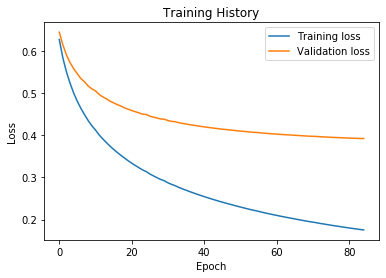

In [28]:
epochs = len(loss_tr_count)
plt.plot(list(range(epochs)), loss_tr_count, label = 'Training loss')
plt.plot(list(range(epochs)), loss_dev_count, label = 'Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()

#### Explanation
My model overfits since it fails to generalise to the validation set. We know this because the predictions made for the training data are significantly more accurate than the validation data, which is visualised on the plot. The validation loss curve appears to flatten whilst the training loss continues to fall after each epoch. The regularisation parameter was increased to try and combat this.

Compute accuracy, precision, recall and F1-scores:

In [29]:
preds_test_count = predict_class(X_test_count, w_count)

In [30]:
# fill in your code...
print('Accuracy:', accuracy_score(Y_test,preds_test_count))
print('Precision:', precision_score(Y_test,preds_test_count))
print('Recall:', recall_score(Y_test,preds_test_count))
print('F1-Score:', f1_score(Y_test,preds_test_count))

Accuracy: 0.8325
Precision: 0.824390243902439
Recall: 0.845
F1-Score: 0.8345679012345678


Finally, print the top-10 words for the negative and positive class respectively.

In [31]:
pos_index = np.argpartition(w_count, -10)[-10:]
top10pos = [vocab_id[i] for i in pos_index]
top10pos

['movies',
 'world',
 'both',
 'also',
 'many',
 'fun',
 'great',
 'seen',
 'well',
 'life']

In [32]:
neg_index = np.argpartition(w_count, 10)[:10]
top10neg = [vocab_id[i] for i in neg_index]   
top10neg

['worst',
 'boring',
 'only',
 'script',
 'bad',
 'unfortunately',
 'why',
 'any',
 'plot',
 'nothing']

#### If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?


All ngrams expressing objective sentiment would be useful as features to classify a review. For example 'great', 'boring' and 'fun'. These words would work in a different domain. Words like 'many', where the sentiment is contextual or subjective would not generalise to different domains very well. For example, 'only' Windows 7 for a laptop would be classified as negative but a 'only' £1 corking fee at the restaurant would be classified as positive. For that reason, if we used the same features for a different domain I don't think it would generalise as well.

## Train and Evaluate Logistic Regression with TF.IDF vectors

Follow the same steps as above (i.e. evaluating count n-gram representations).


In [33]:
w_tfidf, loss_tr_tfidf, loss_dev_tfidf = SGD(X_tr_tfidf, Y_tr, 
                         X_dev=X_dev_tfidf, 
                         Y_dev=Y_dev, 
                         lr=0.00001, 
                         alpha=0.00001,
                         epochs=80, tolerance=0.00001)

Epoch 1 | Train loss: 0.612224 | Val loss: 0.661897
Epoch 2 | Train loss: 0.563750 | Val loss: 0.640820
Epoch 3 | Train loss: 0.527255 | Val loss: 0.628350
Epoch 4 | Train loss: 0.497606 | Val loss: 0.615468
Epoch 5 | Train loss: 0.473010 | Val loss: 0.603989
Epoch 6 | Train loss: 0.453124 | Val loss: 0.595426
Epoch 7 | Train loss: 0.435796 | Val loss: 0.587308
Epoch 8 | Train loss: 0.420905 | Val loss: 0.579911
Epoch 9 | Train loss: 0.407370 | Val loss: 0.575017
Epoch 10 | Train loss: 0.395020 | Val loss: 0.569094
Epoch 11 | Train loss: 0.383862 | Val loss: 0.563073
Epoch 12 | Train loss: 0.373840 | Val loss: 0.559188
Epoch 13 | Train loss: 0.364423 | Val loss: 0.553462
Epoch 14 | Train loss: 0.357258 | Val loss: 0.552199
Epoch 15 | Train loss: 0.347605 | Val loss: 0.546967
Epoch 16 | Train loss: 0.341592 | Val loss: 0.541707
Epoch 17 | Train loss: 0.332685 | Val loss: 0.538888
Epoch 18 | Train loss: 0.325831 | Val loss: 0.535682
Epoch 19 | Train loss: 0.319733 | Val loss: 0.532460
Ep

Now plot the training and validation history per epoch. Does your model underfit, overfit or is it about right? Explain why.

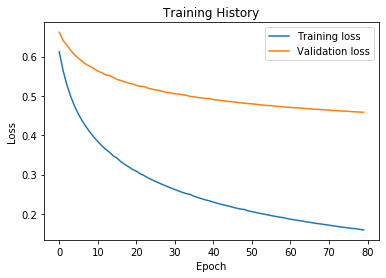

In [34]:
epochs = len(loss_tr_tfidf)
plt.plot(list(range(epochs)), loss_tr_tfidf, label = 'Training loss')
plt.plot(list(range(epochs)), loss_dev_tfidf, label = 'Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()

Compute accuracy, precision, recall and F1-scores:

In [35]:
preds_test_tfidf = predict_class(X_test_tfidf, w_tfidf)

print('Accuracy:', accuracy_score(Y_test,preds_test_tfidf))
print('Precision:', precision_score(Y_test,preds_test_tfidf))
print('Recall:', recall_score(Y_test,preds_test_tfidf))
print('F1-Score:', f1_score(Y_test,preds_test_tfidf))

Accuracy: 0.8275
Precision: 0.8164251207729468
Recall: 0.845
F1-Score: 0.8304668304668306


Print top-10 most positive and negative words:

In [36]:
pos_index_tfidf = np.argpartition(w_tfidf, -10)[-10:]
top10pos_tfidf = [vocab_id[i] for i in pos_index_tfidf]
top10pos_tfidf

['quite',
 'world',
 'life',
 'many',
 'also',
 'seen',
 'both',
 'fun',
 'well',
 'great']

In [37]:
neg_index_tfidf = np.argpartition(w_tfidf, 10)[:10]
top10neg_tfidf = [vocab_id[i] for i in neg_index]   
top10neg_tfidf

['worst',
 'boring',
 'only',
 'script',
 'bad',
 'unfortunately',
 'why',
 'any',
 'plot',
 'nothing']

### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

##### TFIDF
lr=0.00001, alpha=0.00001, epochs=80

- Low learning rate to prevent the model from learning too much in one epoch, which results in a loss increase.
- Low regularisation parameter because tfidf regularises the data more than count already.
- 80 epochs because the tolerance is reached in much fewer.

##### Count
lr=0.0001, alpha=0.001, epochs=100

- Increased regularisation to generalise to validation set.
- Increase learning rate to speed up training.
- Default 100 epochs due to time constraints.


An increased learning rate means we can do less epochs. If epochs = 10 and lr = 1, we can achieve same effect with epochs = 5 and lr = 2. A larger regularisation strength can close the gap between training loss and validation loss. A large difference between these two losses is indicative of a model that overfits. 





## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  |  0.824 | 0.845  | 0.835  |
| BOW-tfidf  |  0.856 | 0.775  | 0.814  |


# Multi-class Logistic Regression 

Now you need to train a Multiclass Logistic Regression (MLR) Classifier by extending the Binary model you developed above. You will use the MLR model to perform topic classification on the AG news dataset consisting of three classes:

- Class 1: World
- Class 2: Sports
- Class 3: Business

train: 2,400. 800 per class

You need to follow the same process as in Task 1 for data processing and feature extraction by reusing the functions you wrote.

In [39]:
vocab2, df2, ngram_counts = get_vocab(train_text2, n=3, keep_topN=5000, stop_words=stop_words)
print(len(vocab2))
print()
print(list(vocab2)[:100])
print()
print(Counter(df2).most_common()[:10])

5000

['paid', 'new homes', 'before', 'Minister Alexander', 'KINGSTON', 'Adam Nelson', 'States over', 'thousands', 'investors put', 'Price', 'Minister Tony', 'retailer Tuesday', 'today after', 'Palestinian prisoners', 'bought beaten down', 'challenges', 'PARIS Reuters', 'political', 'qualifying Olympic', 'even more', 'eased fears', 'Tuesday showed', 'Likud party', 'Michael', 'bases', 'BHP Billiton', 'Diego Padres', 'Brian Ching', 'linked', 'previous', 'Tuesday allowed investors', 'soldier killed', 'slumping', 'thrown', 'walk', 'Reuters New', 'States men', 'murder British backpacker', 'Walker', 'MW', 'second half', 'WASHINGTON Reuters', 'boy', 'renegade Afghan', 'cost', 'Al Maktoum', 'Costas Kenteris', 'suspended', 'land', 'Republican', 'Reuters American', 'Mac', 'defending champion', 'hellip', 'November', 'wife', 'Wholesale', 'judges', 'initial stock', 'Jays', 'report showing', 'Tomas Berdych Czech', 'highly anticipated', 'watch', 'defused bomb near', 'order', 'Wal Mart Stores', 'medal

In [40]:
vocab_id2 = {i:list(vocab2)[i] for i in range(len(vocab2))}

X_tr2 = extract_X_ngram(train_text2)
X_tr_count2 = vectorise(X_tr2, vocab2)

X_test2 = extract_X_ngram(test_text2)
X_test_count2 = vectorise(X_test2, vocab2)

X_dev2 = extract_X_ngram(dev_text2)
X_dev_count2 = vectorise(X_dev2, vocab2)

In [41]:
def count2tfidf(df, X):
    
    X_tfidf = np.zeros(X.shape)
    df_counts = list(df.values())
    idf = [log(len(X_tr)/i) for i in df_counts]
    
    for i in range(len(X)):
        X_tfidf[i] = X[i]*idf
        
    return X_tfidf

X_tr_tfidf2 = count2tfidf(df2, X_tr_count2)
X_test_tfidf2 = count2tfidf(df2, X_test_count2)
X_dev_tfidf2 = count2tfidf(df2, X_dev_count2)

Now you need to change `SGD` to support multiclass datasets. First you need to develop a `softmax` function. It takes as input:

- `z`: array of real numbers 

and returns:

- `smax`: the softmax of `z`

In [296]:
def softmax(z):
    e_z = np.exp(z.T)
    smax = e_z/sum(e_z)
    return smax.T

Then modify `predict_proba` and `predict_class` functions for the multiclass case:

In [347]:
def predict_proba2(X, w):
    preds_proba = []
    z = np.dot(X, w)
    if len(z) == 3:
        preds_proba = softmax(z)
    else:
        for row in z:
            preds_proba.append(softmax(row))
    preds_proba = np.array(preds_proba)
    return preds_proba

In [348]:
def predict_class2(X, weights):
    
    probs = predict_proba2(X, weights)
    preds_class = [i.argmax()+1 for i in probs]
    
    return preds_class

Toy example and expected functionality of the functions above:

In [349]:
X = np.array([[0.1,0.2],
              [0.2,0.1],
              [0.1,-0.2]])
w = np.array([[2,-5],
              [-5,2]])

2 [0.1 0.2]
1 [0.2 0.1]
1 [ 0.1 -0.2]


(2400, 5000)

In [350]:
predict_proba2(X, w)

array([[0.33181223, 0.66818777],
       [0.66818777, 0.33181223],
       [0.89090318, 0.10909682]])

`array([[0.33181223, 0.66818777],
       [0.66818777, 0.33181223],
       [0.89090318, 0.10909682]])`

In [351]:
predict_class2(X, w)

2 [0.33181223 0.66818777]
1 [0.66818777 0.33181223]
1 [0.89090318 0.10909682]


`array([2, 1, 1])`

Now you need to compute the categorical cross entropy loss (extending the binary loss to support multiple classes).

In [449]:
def categorical_loss(X, Y, weights, num_classes=3, alpha=0.00001):
    m = len(Y)
    pred = predict_proba2(X, weights.T)
    pred = np.log(pred + alpha)
    y_c = []
    
    for i in range(int(num_classes)):
        y = list((Y == i+1).astype(int))
        y_c.append(y)
    
    y_c = np.array(y_c)    
    l = (-1/m)*np.sum(y_c.T * pred)
    # - log likelihood of the true class. y = 0 or 1. c = 1, 2 or 3

    return l


Finally you need to modify SGD to support the categorical cross entropy loss:

In [431]:
def SGD2(X_tr, Y_tr, X_dev=[], Y_dev=[], num_classes=3, lr=0.01, alpha=0.00001, epochs=5, tolerance=0.0001, print_progress=True):
    
    training_loss_history = []
    validation_loss_history = []
    w = np.zeros((num_classes, len(X_tr.T)))
    
    # Parallel iteration of X and Y
    for epoch in range(epochs):
        # Shuffle X, y and vocab using same permutation
        perm = np.random.permutation(len(Y_tr))
        X_tr, Y_tr = X_tr[perm], Y_tr[perm]
        for row, label in zip(X_tr, Y_tr):
            for i in range(num_classes):
                if label == i+1:
                    pred = predict_proba2(row, w.T)
                    #print(pred.shape, pred)
                    dl_dw = pred[i]*row - row + 2*alpha*w[i]
                    w[i] -= lr*dl_dw
        l = categorical_loss(X_tr, Y_tr, w, num_classes, alpha)
        l_val = categorical_loss(X_dev, Y_dev, w, num_classes, alpha)
        training_loss_history.append(l)
        validation_loss_history.append(l_val)
        
        if print_progress == True:
            print('Epoch {0} | Train loss: {1:3f} | Val loss: {2:3f}'.format(epoch+1, l, l_val))

        if epoch > 0 and (validation_loss_history[epoch-1] - validation_loss_history[epoch]) < tolerance:
             break
    return w, training_loss_history, validation_loss_history

Now you are ready to train and evaluate you MLR following the same steps as in Task 1 for both Count and tfidf features:

In [432]:
#Count
w_count, loss_tr_count, dev_loss_count = SGD2(X_tr_count2, Y_tr2, 
                                             X_dev=X_dev_count2, 
                                             Y_dev=Y_dev2,
                                             num_classes=3,
                                             lr=0.001, 
                                             alpha=0.001, 
                                             epochs=200)

Epoch 1 | Train loss: 1.049852 | Val loss: 1.060291
Epoch 2 | Train loss: 1.009147 | Val loss: 1.028520
Epoch 3 | Train loss: 0.972977 | Val loss: 0.999973
Epoch 4 | Train loss: 0.940728 | Val loss: 0.974255
Epoch 5 | Train loss: 0.911848 | Val loss: 0.951030
Epoch 6 | Train loss: 0.885885 | Val loss: 0.930009
Epoch 7 | Train loss: 0.862429 | Val loss: 0.910921
Epoch 8 | Train loss: 0.841166 | Val loss: 0.893555
Epoch 9 | Train loss: 0.821770 | Val loss: 0.877692
Epoch 10 | Train loss: 0.804029 | Val loss: 0.863155
Epoch 11 | Train loss: 0.787723 | Val loss: 0.849818
Epoch 12 | Train loss: 0.772670 | Val loss: 0.837536
Epoch 13 | Train loss: 0.758732 | Val loss: 0.826204
Epoch 14 | Train loss: 0.745785 | Val loss: 0.815710
Epoch 15 | Train loss: 0.733719 | Val loss: 0.805978
Epoch 16 | Train loss: 0.722443 | Val loss: 0.796935
Epoch 17 | Train loss: 0.711876 | Val loss: 0.788506
Epoch 18 | Train loss: 0.701941 | Val loss: 0.780635
Epoch 19 | Train loss: 0.692583 | Val loss: 0.773269
Ep

Epoch 155 | Train loss: 0.396254 | Val loss: 0.607483
Epoch 156 | Train loss: 0.395561 | Val loss: 0.607364
Epoch 157 | Train loss: 0.394873 | Val loss: 0.607239
Epoch 158 | Train loss: 0.394192 | Val loss: 0.607122
Epoch 159 | Train loss: 0.393514 | Val loss: 0.607002
Epoch 160 | Train loss: 0.392842 | Val loss: 0.606886
Epoch 161 | Train loss: 0.392174 | Val loss: 0.606769
Epoch 162 | Train loss: 0.391513 | Val loss: 0.606656
Epoch 163 | Train loss: 0.390857 | Val loss: 0.606546
Epoch 164 | Train loss: 0.390206 | Val loss: 0.606436
Epoch 165 | Train loss: 0.389559 | Val loss: 0.606328
Epoch 166 | Train loss: 0.388916 | Val loss: 0.606218
Epoch 167 | Train loss: 0.388282 | Val loss: 0.606121


In [451]:
# TFIDF
w_tfidf, loss_tr_tfidf, dev_loss_tfidf = SGD2(X_tr_count2, Y_tr2, 
                                             X_dev=X_dev_count2, 
                                             Y_dev=Y_dev2,
                                             num_classes=3,
                                             lr=0.001, 
                                             alpha=0.001, 
                                             epochs=200)

Epoch 1 | Train loss: 1.049834 | Val loss: 1.060275
Epoch 2 | Train loss: 1.009151 | Val loss: 1.028529
Epoch 3 | Train loss: 0.972994 | Val loss: 0.999985
Epoch 4 | Train loss: 0.940741 | Val loss: 0.974290
Epoch 5 | Train loss: 0.911870 | Val loss: 0.951080
Epoch 6 | Train loss: 0.885915 | Val loss: 0.930060
Epoch 7 | Train loss: 0.862483 | Val loss: 0.910991
Epoch 8 | Train loss: 0.841209 | Val loss: 0.893627
Epoch 9 | Train loss: 0.821811 | Val loss: 0.877756
Epoch 10 | Train loss: 0.804066 | Val loss: 0.863223
Epoch 11 | Train loss: 0.787756 | Val loss: 0.849885
Epoch 12 | Train loss: 0.772708 | Val loss: 0.837608
Epoch 13 | Train loss: 0.758772 | Val loss: 0.826268
Epoch 14 | Train loss: 0.745823 | Val loss: 0.815769
Epoch 15 | Train loss: 0.733758 | Val loss: 0.806034
Epoch 16 | Train loss: 0.722477 | Val loss: 0.796985
Epoch 17 | Train loss: 0.711910 | Val loss: 0.788564
Epoch 18 | Train loss: 0.701974 | Val loss: 0.780692
Epoch 19 | Train loss: 0.692612 | Val loss: 0.773326
Ep

Epoch 155 | Train loss: 0.396259 | Val loss: 0.607505
Epoch 156 | Train loss: 0.395564 | Val loss: 0.607377
Epoch 157 | Train loss: 0.394876 | Val loss: 0.607254
Epoch 158 | Train loss: 0.394193 | Val loss: 0.607135
Epoch 159 | Train loss: 0.393515 | Val loss: 0.607012
Epoch 160 | Train loss: 0.392841 | Val loss: 0.606888
Epoch 161 | Train loss: 0.392175 | Val loss: 0.606776
Epoch 162 | Train loss: 0.391515 | Val loss: 0.606667
Epoch 163 | Train loss: 0.390859 | Val loss: 0.606557
Epoch 164 | Train loss: 0.390207 | Val loss: 0.606448
Epoch 165 | Train loss: 0.389562 | Val loss: 0.606347
Epoch 166 | Train loss: 0.388921 | Val loss: 0.606241
Epoch 167 | Train loss: 0.388285 | Val loss: 0.606140
Epoch 168 | Train loss: 0.387656 | Val loss: 0.606048


Plot training and validation process and explain if your model overfit, underfit or is about right:

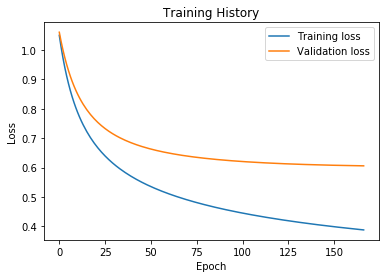

In [455]:
# Count
epochs = len(loss_tr_count)
plt.plot(list(range(epochs)), loss_tr_count, label = 'Training loss')
plt.plot(list(range(epochs)), dev_loss_count, label = 'Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History Count')
plt.legend()

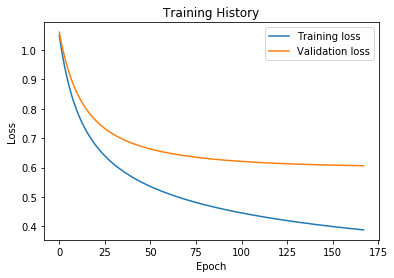

In [457]:
# TFIDF
epochs = len(loss_tr_tfidf)
plt.plot(list(range(epochs)), loss_tr_tfidf, label = 'Training loss')
plt.plot(list(range(epochs)), dev_loss_tfidf, label = 'Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training History TFIDF')
plt.legend()

Compute accuracy, precision, recall and F1-scores:

In [440]:
# Count
preds_te = predict_class2(X_test_count2, w_count.T)

print('Accuracy:', accuracy_score(Y_test2,preds_te))
print('Precision:', precision_score(Y_test2,preds_te,average='macro'))
print('Recall:', recall_score(Y_test2,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_test2,preds_te,average='macro'))

Accuracy: 0.7366666666666667
Precision: 0.7453267947258396
Recall: 0.7366666666666667
F1-Score: 0.7363437588992419


Print the top-10 words for each class respectively.

In [472]:
# politics, sport, business
pol_index = np.argpartition(w_count[0], -10)[-10:]
top10pol = [vocab_id2[i] for i in pol_index]
top10pol
w_count[0]

['won men',
 'homeless',
 'Olympic gold medal',
 'Real',
 'psychological',
 'Baghdad',
 'time eight',
 'playoff Sunday',
 'earnings rose',
 'charges']

### Now evaluate BOW-tfidf...

In [452]:
# TFIDF

preds_te_tfidf = predict_class2(X_test_tfidf2, w_tfidf.T)

print('Accuracy:', accuracy_score(Y_test2,preds_te_tfidf))
print('Precision:', precision_score(Y_test2,preds_te_tfidf,average='macro'))
print('Recall:', recall_score(Y_test2,preds_te_tfidf,average='macro'))
print('F1-Score:', f1_score(Y_test2,preds_te_tfidf,average='macro'))

Accuracy: 0.7388888888888889
Precision: 0.7472416351923837
Recall: 0.7388888888888889
F1-Score: 0.7388514662856366


### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

Hyperparameters were chosen in a similar way to task one, however I was unable to achieve a validation loss I was happy with.

## Full Results

Add here your results:

| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  | 0.745  |  0.737 |  0.736 |
| BOW-tfidf  |  0.747 | 0.739  | 0.739  |
